In [1]:
import dfBasics
import common
import encoder
import pfAdapt
import charts


Setup Complete


In [2]:
import pandas as pd
from pyspark.sql import functions

# Lib functions

# Main

In [3]:
sparkSession = dfBasics.getSparkSession()

In [133]:
df = sparkSession.read.parquet('hdfs://172.30.17.145:8020/user/admin/stage1/v1/labelencoder/*/*')
#.limit(100000) 

In [ ]:
missingSchemaids = [ 1480883705,  -404024316,  -183769575,  2031641327, -1576843338,
                     -660710506,  -208259125,  -650561809,   -39609584, -1115728007]

df = sparkSession.read.parquet('hdfs://172.30.17.145:8020/user/admin/stage1/flat_*/*') 
df = df.filter(~df['schemaid'].isin(*missingSchemaids)) \
       .withColumn('timestamp', col('timestamp').cast('long')) 

In [ ]:
df = sparkSession.read.parquet('hdfs://172.30.17.145:8020/sla_sql_data/*/*') 

In [ ]:
df = sparkSession.read.parquet('hdfs://172.30.17.145:8020/user/admin/stage1/flat_' + str(cycle) + '/*') \
    .withColumn('timestamp', col('timestamp').cast('long')) 

# Functions

In [5]:
def getMissingSchemaids(pf,hashes):
    a = np.array([])
    for hash in hashes:  
        if len(pf[pf['hashvalue'] == hash]) != len(pd.unique(pf[pf['hashvalue'] == hash]['timestamp'])):
            value = pd.unique(pf[pf['hashvalue'] == hash]['schemaid'])
            if (value in a) == False:
                a = np.append(a,value)
    return a.astype(int)

In [ ]:
def dfcolumnSeries(column):
    return df.select(column).dropDuplicates()
def dfcolumnCount(column):
    return dfcolumnSeries(column).count()

In [ ]:
from functools import reduce
import operator

def eval1(filteredrows):
    element = staticfeatureset.index[0]
    res = filteredrows[element].eq(staticfeatureset[element])

    for element in staticfeatureset.index:
        res = reduce(operator.and_,(res,filteredrows[element].eq(staticfeatureset[element])))
    return res

In [121]:
# find out variable columns and type of value
from pyspark.sql.functions import col

selected = ['timestamp', 'value','year','month', 'day', 'hour', 'minute']

def getDFvalueWithHash(currenthash):
    pfm = df.filter(col("hashvalue") == currenthash) \
            .withColumn('value', col('value').cast('int'))\
            .select(selected).toPandas().sort_values('timestamp').reset_index() 
    return pfm

def getDFvalueWithHashSchema(schemaid,currenthash):
    pfm = df.filter(col("hashvalue") == currenthash) \
            .filter(col("schemaid") == schemaid) \
            .withColumn('value', col('value').cast('int'))\
            .select(selected).toPandas().sort_values('timestamp').reset_index() 
    return pfm

def getIgroupHashes(igroup):
        return df.filter(col("igroup") == igroup).select(["hashvalue"]).dropDuplicates().toPandas()['hashvalue']

In [111]:
# remove columns which are variable to find related metrics
def getStaticFeatures(_hash):
    allcolumns = filteredrows[filteredrows['hashvalue'] == _hash].columns
    skipcolumns = ['timestamp', 'value',  'hashvalue', 'igroup', 'inode', 'year', 'month', 'day', 'hour', 'minute']
    featurecolumns = allcolumns[~allcolumns.isin(skipcolumns)]
    featurecolumns = pfAdapt.getVariableUniqueColums(filteredrows[featurecolumns])
    staticfeatureset = filteredrows[filteredrows['hashvalue'] == _hash][featurecolumns].iloc[0]
    return staticfeatureset

# Info

In [134]:
row1 = df.agg({"timestamp": "min"}).collect()[0]
row2 = df.agg({"timestamp": "max"}).collect()[0]

dfminTimestamp = row1["min(timestamp)"]
dfmaxTimestamp = row2["max(timestamp)"]
dfrowCount     = df.count()
dfcolumnCount  = len(df.columns)

In [135]:
print('min:',common.date(dfminTimestamp), 'max:', common.date(dfmaxTimestamp))
print('rows:',dfrowCount,'columns:',dfcolumnCount)

min: 2020-02-24 10:27:02+01:00 max: 2020-05-09 21:24:12+02:00
rows: 6482928136 columns: 63


In [136]:
columns = df.limit(1).toPandas().columns
withoutColumns = ['timestamp', 'value','schemaid', 'hashvalue']
columns = columns[~columns.isin(withoutColumns)]

In [ ]:
#
schemas = dfcolumnSeries('schemaid').toPandas()['schemaid']
igroups = dfcolumnSeries('igroup').toPandas()['igroup']

schemaidCount  = dfcolumnCount('schemaid')
hashvalueCount = dfcolumnCount('hashvalue')
igroupCount = dfcolumnCount('igroup')
print('schemaidCount: ',schemaidCount,'hashvalueCount: ',hashvalueCount,'igroupCount: ',igroupCount)

In [138]:
pfall = df.limit(100000).toPandas() 

In [139]:
pfall.head()

,timestamp,value,product,service,__name__,alertname,alertstate,job,severity,code,...,queuename,schemaid,hashvalue,igroup,inode,year,month,day,hour,minute
0,1587819506,0,0,5,51,1,0,9,0,4,...,4,-1648973472,1723805959,7,2,2020,4,25,14,58
1,1587819506,1,0,4,305,1,0,8,0,4,...,4,607903666,1204139744,6,6,2020,4,25,14,58
2,1587819506,0,0,1,346,1,0,2,0,4,...,4,-2049409982,649290262,1,2,2020,4,25,14,58
3,1587819506,5,0,1,3,1,0,10,0,4,...,4,1629035211,1367422994,12,1,2020,4,25,14,58
4,1587819506,0,0,4,347,1,0,8,0,4,...,4,-2049409982,-836471039,6,5,2020,4,25,14,58


In [140]:
hashes = getIgroupHashes(6)

In [141]:
_hash = hashes[10]
staticfeatureset = getStaticFeatures(_hash)

In [142]:
relatedhashes = pd.unique(pfall[eval1(pfall)]['hashvalue'])
relatedhashes

array([-841828430, -148435725])

In [143]:
def getDataForRelatedHashes(relatedhashes):
    data2 = pd.DataFrame()
    start = True
    for hash_ in relatedhashes:
        c1 =  getDFvalueWithHash(int(hash_))
        if start:
            data2['date'] = c1['timestamp']
            start = False
        data2[str(hash_)] =  c1['value']
    return data2

In [144]:
data = getDataForRelatedHashes(relatedhashes)
len(data)

37834

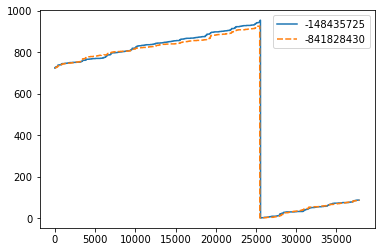

In [145]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#sns.lineplot(data=data2.iloc[:, :2])
sns.lineplot(data=data.iloc[:, 1:])

In [130]:
data

,date,-841828430,-148435725
0,1587452298,724,723.0
1,1587452328,724,723.0
2,1587452358,724,723.0
3,1587452388,724,723.0
4,1587452418,724,723.0
...,...,...,...
37829,1588514436,87,NaN
37830,1588514466,87,NaN
37831,1588514496,87,NaN
37832,1588514526,87,NaN


In [8]:
filteredrows = pfall[pfall['igroup'] == 6]

len(filteredrows)
hashes = pd.unique(filteredrows['hashvalue'])

In [21]:
import numpy as np
getMissingSchemaids(pfall,hashes)

array([1629035211, -837577289])

In [82]:
data2 = pd.DataFrame()
#pfm = getDFvalueWithHash(int(relatedhashes[0]))
#
data2['date'] = dt['timestamp'].astype(str)
data2['value'] = dt['value']

In [70]:
#hashes_d = dfcolumnSeries('hashvalue').toPandas()['hashvalue']
hashes_d = df.select(['hashvalue','schemaid']).dropDuplicates().toPandas()

In [71]:
len(pd.unique(hashes_d['hashvalue']))


27285

In [80]:
#len(pd.unique(hashes_d))


dt = getDFvalueWithHash(int(hashes_d['schemaid'][0]),int(hashes_d['hashvalue'][0]))


In [81]:
# check, if it is unique
len(dt['timestamp']), len(dt)

(19200, 19200)

In [58]:
len(pd.unique(pfall['hashvalue']))

26140

In [28]:
print(len(hashes))
len(pd.unique(pfall['hashvalue']))

3903


27195

In [ ]:
#getInfoForSchemas(filteredrows)
#len(pd.unique(filteredrows['__name__']))
#getEncoder('__name__').inverse_transform(pd.unique(filteredrows['__name__']))

In [ ]:
pfall[(pfall['schemaid'] == 1629035211) & (pfall['timestamp'] == 1587819506)]

In [ ]:
#getEncoder('igroup').inverse_transform(igroups)
for igroup in igroups:
    filteredrows = pfall[pfall['igroup'] == igroup]
    count = len(pd.unique(filteredrows['inode']))
    if count > 1:
        print(getEncoder('igroup').inverse_transform([igroup]),igroup,count)

In [ ]:
for hash_ in hashes:
    metric = filteredrows[filteredrows['hashvalue']==hash_]
    count = len(pd.unique(metric['value']))
    if count > 3:
        print(hash_,count)

In [10]:
#continue with hash
#_hash=-2018833881
_hash=-283862276

In [ ]:
# !!!!!!!!!!! missing schemas
getMissingSchemaids(pfall)

In [ ]:
filteredrows[filteredrows['hashvalue'] == _hash]
filteredrows[filteredrows['hashvalue'] == _hash][featurecolumns].iloc[0]['__name__']

In [ ]:


#['schemaid','igroup']

#filteredrows[featurecolumns].head()
#getVariableUniqueColums(filteredrows[featurecolumns])

# there are still too many columns for _hash
#len(getVariableUniqueColums(filteredrows[featurecolumns]))
#len(featurecolumns)


# there are no variable columns left
#getVariableUniqueColums(filteredrows[filteredrows['hashvalue'] == _hash][featurecolumns])

# static feature values for metric _hash

#staticfeatureset[featurecolumns[1]]
#staticfeatureset


#featurecolumns

array([ 409530429, -283862276])

In [ ]:
currenthash     = int(relatedhashes[1])
currentfeatures = filteredrows[filteredrows['hashvalue'] == currenthash].iloc[0]
currentfeatures['igroup'],currentfeatures['inode'],currentfeatures['hashvalue'],getEncoder('__name__').inverse_transform([currentfeatures['__name__']])[0]

In [ ]:
pfm

In [34]:
#data2 = data2.sort_values('date').reset_index()
c1

,index,timestamp,value,year,month,day,hour,minute
0,16855,1587452298,177554895,2020,4,21,8,58
1,16856,1587452328,177556531,2020,4,21,8,58
2,16857,1587452358,177560068,2020,4,21,8,59
3,16858,1587452388,177563899,2020,4,21,8,59
4,16859,1587452418,177566507,2020,4,21,9,0
...,...,...,...,...,...,...,...,...
37922,37922,1588514436,22744362,2020,5,3,16,0
37923,37923,1588514466,22749016,2020,5,3,16,1
37924,37924,1588514496,22756481,2020,5,3,16,1
37925,37925,1588514526,22765271,2020,5,3,16,2


In [ ]:
data2

In [ ]:
ax = createLineplot(data2,16,10,1.4,title="",skip=500)
label(ax,10,90)

In [ ]:
data2.iloc[2]

In [84]:
pfall.head()

,index,timestamp,value,year,month,day,hour,minute
0,0,1588514870,0,2020,5,3,16,7
1,1,1588514900,0,2020,5,3,16,8
2,2,1588514930,0,2020,5,3,16,8
3,3,1588514960,0,2020,5,3,16,9
4,4,1588514990,0,2020,5,3,16,9
...,...,...,...,...,...,...,...,...
19195,19195,1589052132,0,2020,5,9,21,22
19196,19196,1589052162,0,2020,5,9,21,22
19197,19197,1589052192,0,2020,5,9,21,23
19198,19198,1589052222,0,2020,5,9,21,23


In [ ]:
filteredrows[featurecolumns].head()

In [ ]:
# find out variable columns and type of value
#getVariableUniqueColums(pfm)
#selected = ['timestamp', 'value','year','month', 'day', 'hour', 'minute']

#which inode is used by metri hashvalue
used_inode = filteredrows[filteredrows['hashvalue'] == _hash]['inode'].iloc[0]

# other inodes for the igroup
inodes_igroup = pd.unique(filteredrows[filteredrows['igroup'] == 6]['inode'])
otherinodes = inodes_igroup[inodes_igroup!=used_inode]

#
pd.unique(filteredrows[filteredrows['igroup'] == 6]['__name__'])
pd.unique(filteredrows[(filteredrows['igroup'] == 6) & (filteredrows['__name__'] == 309)]['logical_system'])

In [ ]:
filteredrows[filteredrows['inode'] == inodes_igroup[0]]['hashvalue']


In [ ]:

        
metric = filteredrows[filteredrows['hashvalue']==_hash]
#metric = filteredrows[filteredrows['hashvalue']==hashes[0]]
#usedcolumns(metric)

keep = getVariableUniqueColums(metric)
#keepcolumns(dataall,keep)
#keep
len(metric),len(pd.unique(metric['value'])), pd.unique(metric['value'])
metric

In [ ]:
pfall1 = pfall[pfall['schemaid'] == schemas[0]]
mdcountsall = pfall1.groupby(['igroup','hashvalue'])
#['igroup'].count() 
#data2 = pd.DataFrame()
mdcountsall

In [ ]:
getEncoder('__name__').inverse_transform([pfall1.iloc[0]['__name__']])[0]

In [ ]:
def createData(pfall,month,outcome) :
    if outcome < 2 :
        mdcountsall = pfall[(pfall['month'] == month) & (pfall['outcome'] == outcome)].groupby(['year','month','day','hour'])['outcome'].count()
    else :
        if (month > 0) & (month < 13) :
            mdcountsall = pfall[(pfall['month'] == month)].groupby(['year','month','day','hour'])['outcome'].count()
        else :
            mdcountsall = pfall.groupby(['year','month','day','hour'])['outcome'].count()    
    a,b,c,d = get_ymdh(mdcountsall)
    data2 = pd.DataFrame()
    data2['date'] = get_ymdh_string(a,b,c,d)
    data2['outcome'] =  mdcountsall.reset_index()['outcome'].astype(int) 

    #for pivot table
    data2['hours'] =  d.astype(int) 
    data2['days']  =  c.astype(int) 
    piv = pd.pivot_table(data2, values="outcome",index=["hours"], columns=["days"], fill_value=0)
    return data2

In [ ]:
pfall.head()